In [1]:
import h5py
import glob
import os
import sys
import sympy
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, accuracy_score
from sklearn.preprocessing import StandardScaler
import tensorflow.keras.backend as K
from sklearn.preprocessing import StandardScaler, LabelEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import roc_curve, auc, accuracy_score, r2_score
from tensorflow.keras.regularizers import Regularizer
from tensorflow.keras.initializers import Zeros, RandomNormal
from tensorflow.keras.layers import *
from tensorflow import keras
from tensorflow.keras import layers, models, Model
from sklearn.metrics import roc_curve, auc
import tensorflow.keras.backend as K
import qkeras
from qkeras import *

np.random.seed(42)
tf.random.set_seed(42)

X_train = np.load('X_train.npy', mmap_mode='r')
X_val = np.load('X_val.npy', mmap_mode='r')
X_test = np.load('X_test.npy', mmap_mode='r')
Y_train = np.load('Y_train.npy', mmap_mode='r')
Y_val = np.load('Y_val.npy', mmap_mode='r')
Y_test = np.load('Y_test.npy', mmap_mode='r')
pt_truth_test = np.load('pt_truth_test.npy', mmap_mode='r')

# model 1 (y-local, y-size)
X_train = X_train[:,:2]
X_val = X_val[:,:2]
X_test = X_test[:,:2]

# model 2 (y-local, [13 y rows of cluster charge])
#X_train = np.delete(X_train, [1], axis=1)
#X_val = np.delete(X_val, [1], axis=1)
#X_test = np.delete(X_test, [1], axis=1)

X_test = X_test[:500000]
Y_test = Y_test[:500000]
pt_truth_test = pt_truth_test[:500000]

print('X_train shape: ' + str(X_train.shape))
print('X_val   shape: ' + str(X_val.shape))
print('X_test  shape: ' + str(X_test.shape))
print('Y_train shape: ' + str(Y_train.shape))
print('Y_val   shape: ' + str(Y_val.shape))
print('Y_test  shape: ' + str(Y_test.shape))
print('pt_truth_test  shape: ' + str(pt_truth_test.shape))

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

X_train shape: (226993, 2)
X_val   shape: (18917, 2)
X_test  shape: (500000, 2)
Y_train shape: (226993, 3)
Y_val   shape: (18917, 3)
Y_test  shape: (500000, 3)
pt_truth_test  shape: (500000,)


## nn model

In [2]:
quantizer = quantized_bits(16, 6, alpha=1)
quantized_relu = 'quantized_relu(16, 6)'

x_input = keras.Input(shape=(X_train.shape[1],), name='input')

x = QDense(128, use_bias=True, name='dense1', kernel_quantizer=quantizer, bias_quantizer=quantizer)(x_input)
x = QActivation(quantized_relu, name='relu1')(x)
    
x = QDense(3, use_bias=True, name='dense2', kernel_quantizer=quantizer, bias_quantizer=quantizer)(x)
x = layers.Softmax(name='softmax')(x)
#x = layers.Activation('sigmoid')(x)

model = keras.Model(x_input, x, name='model')

model.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.001),
              loss='categorical_crossentropy', metrics = ['accuracy'])
#model.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.001),
#              loss='binary_crossentropy', metrics = ['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 2)]               0         
                                                                 
 dense1 (QDense)             (None, 128)               384       
                                                                 
 relu1 (QActivation)         (None, 128)               0         
                                                                 
 dense2 (QDense)             (None, 3)                 387       
                                                                 
 softmax (Softmax)           (None, 3)                 0         
                                                                 
Total params: 771 (3.01 KB)
Trainable params: 771 (3.01 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Epoch 1/120
1774/1774 [==============================] - 1s 646us/step - loss: 0.7500 - accuracy: 0.6534 - val_loss: 0.7261 - val_accuracy: 0.6559
Epoch 2/120
1774/1774 [==============================] - 1s 589us/step - loss: 0.7245 - accuracy: 0.6589 - val_loss: 0.7201 - val_accuracy: 0.6607
Epoch 3/120
1774/1774 [==============================] - 1s 604us/step - loss: 0.7232 - accuracy: 0.6592 - val_loss: 0.7242 - val_accuracy: 0.6591
Epoch 4/120
1774/1774 [==============================] - 1s 594us/step - loss: 0.7224 - accuracy: 0.6587 - val_loss: 0.7194 - val_accuracy: 0.6584
Epoch 5/120
1774/1774 [==============================] - 1s 584us/step - loss: 0.7216 - accuracy: 0.6596 - val_loss: 0.7178 - val_accuracy: 0.6603
Epoch 6/120
1774/1774 [==============================] - 1s 606us/step - loss: 0.7212 - accuracy: 0.6596 - val_loss: 0.7168 - val_accuracy: 0.6615
Epoch 7/120
1774/1774 [==============================] - 1s 545us/step - loss: 0.7210 - accuracy: 0.6596 - val_loss: 0

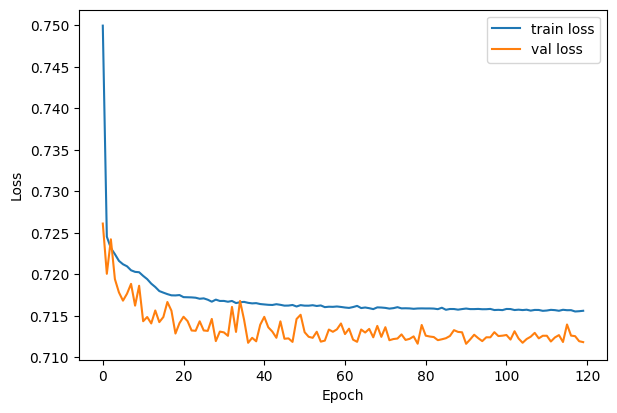

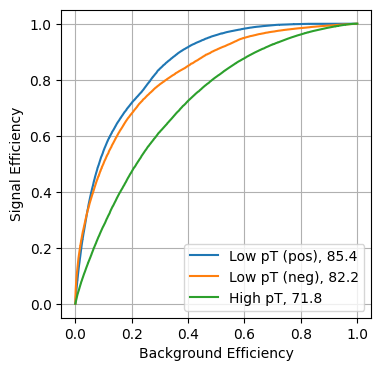

In [3]:
history = model.fit(X_train, Y_train,
                    validation_data = (X_val, Y_val),
                    epochs=120, batch_size=128)

plt.figure(figsize = (15,10))
axes = plt.subplot(2, 2, 1)
axes.plot(history.history['loss'], label = 'train loss')
axes.plot(history.history['val_loss'], label = 'val loss')
axes.legend(loc = "upper right")
axes.set_xlabel('Epoch')
axes.set_ylabel('Loss')


Y_nn_pred = model.predict(X_test)
print("Accuracy: {}".format(accuracy_score(np.argmax(Y_test, axis=1), np.argmax(Y_nn_pred, axis=1))))


def plot_roc(y_test, y_pred, labels):
    for x, label in enumerate(labels):        
        fpr, tpr, _ = roc_curve(y_test[:, x], y_pred[:, x])
        plt.plot(fpr, tpr, label='{0}, {1:.1f}'.format(label, auc(fpr, tpr)*100.), linestyle='-')
    #plt.semilogy()
    #plt.semilogx()
    plt.ylabel("Signal Efficiency")
    plt.xlabel("Background Efficiency")
    #plt.ylim(0.00001, 1)
    #plt.xlim(0.00001, 1)
    plt.grid(True)
    plt.legend(loc='best', fontsize=10)  
    
plt.figure(figsize=(4, 4))
plot_roc(Y_test, Y_nn_pred, ['Low pT (pos)','Low pT (neg)','High pT'])
#plot_roc(Y_test, Y_nn_pred, [' '])

/var/folders/k_/3rw365c56w9f02q8nb4v2r4r0000gn/T/ipykernel_12172/769620210.py:10: RuntimeWarning: invalid value encountered in divide
  proportions_nn = class_001_counts_nn / total_counts_nn


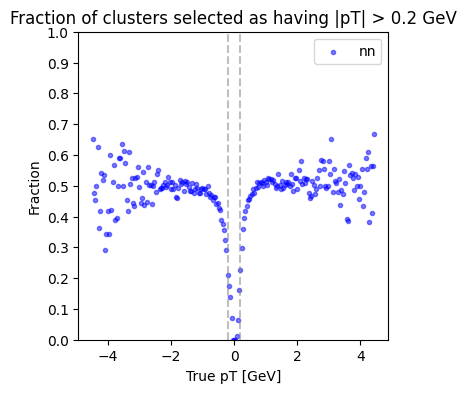

In [4]:
plt.figure(figsize=(4, 4))
custom_bins = np.arange(-4.5, 4.5, 0.04)
bin_centers = 0.5 * (custom_bins[:-1] + custom_bins[1:])

indices_001_nn = np.argmax(Y_nn_pred, axis=1) == 2

total_counts_nn, _ = np.histogram(pt_truth_test, bins=custom_bins)
class_001_counts_nn, _ = np.histogram(pt_truth_test[indices_001_nn], bins=custom_bins)

proportions_nn = class_001_counts_nn / total_counts_nn
proportions_nn = np.nan_to_num(proportions_nn)

plt.scatter(bin_centers, proportions_nn, marker='.', label='nn', alpha=0.5, color='blue')
plt.axvline(x=0.2, color='grey', linestyle='--', alpha=0.5)
plt.axvline(x=-0.2, color='grey', linestyle='--', alpha=0.5)

plt.legend(fontsize=10)
plt.xlabel('True pT [GeV]')
plt.ylabel('Fraction')
plt.title('Fraction of clusters selected as having |pT| > 0.2 GeV')
plt.yticks(np.arange(0, 1.1, 0.1))
#plt.yscale('log')
plt.ylim(0, 1)
plt.legend()
plt.show()

## symbolnet model

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 2)]               0         
                                                                 
 input_sparsity (Input_spar  (None, 2)                 4         
 sity)                                                           
                                                                 
 symbolic__layer (Symbolic_  (None, 40)                380       
 Layer)                                                          
                                                                 
 symbolic__layer_1 (Symboli  (None, 3)                 252       
 c_Layer)                                                        
                                                                 
Total params: 636 (2.48 KB)
Trainable params: 591 (2.31 KB)
Non-trainable params: 45 (180.00 Byte)
____________________________

Epoch 1/100
1774/1774 [==============================] - 5s 1ms/step - loss: 2.4316 - regression_loss: 0.5644 - accuracy: 0.5682 - sparsity_input: 0.0000e+00 - sparsity_model: 0.5240 - sparsity_unary: 0.0000e+00 - sparsity_binary: 0.0000e+00
Epoch 2/100
1774/1774 [==============================] - 2s 1ms/step - loss: 1.4415 - regression_loss: 0.5028 - accuracy: 0.6233 - sparsity_input: 0.0000e+00 - sparsity_model: 0.6787 - sparsity_unary: 0.0000e+00 - sparsity_binary: 0.0000e+00
Epoch 3/100
1774/1774 [==============================] - 2s 1ms/step - loss: 1.0808 - regression_loss: 0.4995 - accuracy: 0.6221 - sparsity_input: 0.0000e+00 - sparsity_model: 0.7487 - sparsity_unary: 0.1470 - sparsity_binary: 0.0617
Epoch 4/100
1774/1774 [==============================] - 2s 1ms/step - loss: 0.7006 - regression_loss: 0.4975 - accuracy: 0.6227 - sparsity_input: 0.0000e+00 - sparsity_model: 0.8121 - sparsity_unary: 0.2557 - sparsity_binary: 0.1000
Epoch 5/100
1774/1774 [=========================

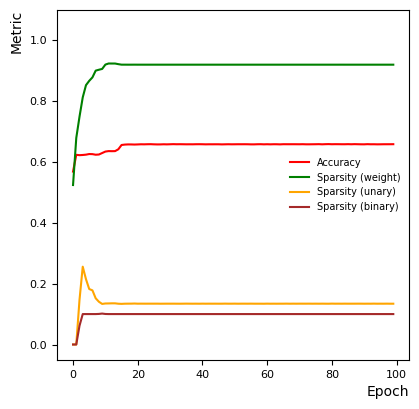

In [5]:
from symbolnet import *

input_dim  = X_train.shape[1]
num_hidden = 1
output_dim = Y_train.shape[1]
model_dim = [input_dim, num_hidden, output_dim]

# operator choices per hidden symbolic layer
operators = [
    [['sin','tanh'], ['*']], # 1st symbolic layer [[unary], [binary]]
    #[['sin','tanh'], ['*']], # 2nd ...
            ]

# number of unary and binary operators per hidden symbolic layer
num_operators = [
    [30, 10], # 1st symbolic layer [num_unary, num_binary]
    #[12, 4], # 2nd ...
]

model = create_model(model_dim=model_dim,
                     operators=operators,
                     num_operators=num_operators)
model[0].summary()

nsr = neuralSR(model,
               # set target sparsity level per pruning type
               alpha_sparsity_input=0.1,
               alpha_sparsity_model=0.9,
               alpha_sparsity_unary=0.1,
               alpha_sparsity_binary=0.1)
nsr.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0003))


h = nsr.fit(X_train, Y_train, epochs=100, batch_size=128)
history = dict()
for key in h.history.keys():
    values = []
    values += h.history[key]
    history[key] = values

size_axis_title=10
size_axis_label=8
size_legend=7
plt.figure(figsize = (10,10))
axes = plt.subplot(2,2,1)
axes.set_ylim([-0.05,1.1])
plt.xticks(fontsize = size_axis_label) 
plt.yticks(fontsize = size_axis_label) 
axes.plot(history['accuracy'], label='Accuracy', linestyle='solid', c='r')
axes.plot(history['sparsity_model'], label='Sparsity (weight)', linestyle='solid', c='g')
#axes.plot(history['sparsity_input'], label='Sparsity (input)', linestyle='solid', c='b')
axes.plot(history['sparsity_unary'], label='Sparsity (unary)', linestyle='solid', c='orange')
axes.plot(history['sparsity_binary'], label='Sparsity (binary)', linestyle='solid', c='brown')
axes.set_xlabel('Epoch', size=size_axis_title, loc='right')
axes.set_ylabel('Metric', size=size_axis_title, loc='top')
axes.legend(loc = 'best', frameon = False, fontsize = size_legend)
plt.show()

15625/15625 [==============================] - 8s 472us/step
Accuracy = 0.48155


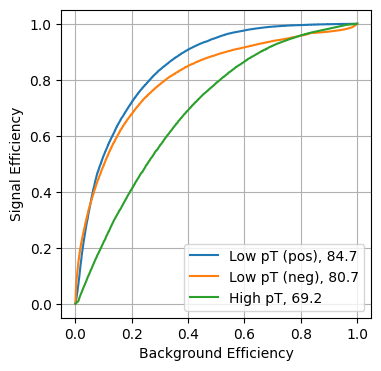

In [6]:
Y_sr_pred = nsr.model.predict(X_test)
print("Accuracy = {}".format(accuracy_score(np.argmax(Y_test, axis=1), np.argmax(Y_sr_pred, axis=1))))

def plot_roc(y_test, y_pred, labels):
    for x, label in enumerate(labels):        
        fpr, tpr, _ = roc_curve(y_test[:, x], y_pred[:, x])
        plt.plot(fpr, tpr, label='{0}, {1:.1f}'.format(label, auc(fpr, tpr)*100.), linestyle='-')
    #plt.semilogy()
    #plt.semilogx()
    plt.ylabel("Signal Efficiency")
    plt.xlabel("Background Efficiency")
    #plt.ylim(0.00001, 1)
    #plt.xlim(0.00001, 1)
    plt.grid(True)
    plt.legend(loc='best', fontsize=10)  
    
plt.figure(figsize=(4, 4))
plot_roc(Y_test, Y_sr_pred, ['Low pT (pos)','Low pT (neg)','High pT'])
#plot_roc(Y_test, Y_sr_pred, [' '])

/var/folders/k_/3rw365c56w9f02q8nb4v2r4r0000gn/T/ipykernel_12172/3141202776.py:9: RuntimeWarning: invalid value encountered in divide
  proportions_sr = class_001_counts_sr / total_counts_sr


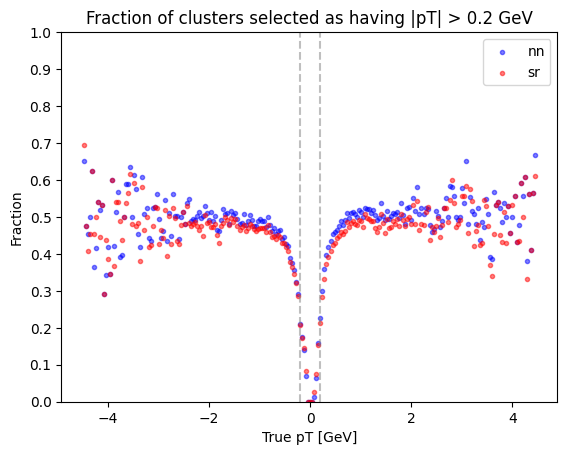

Remaining Inputs after pruning: [[x0 x1]]

Unroll network into symbolic expressions (input sparsity = 0.000; model sparsity = 0.919; unary sparsity = 0.133; binary sparsity = 0.133)
--------------
Mean complexity = 24.7
--------------
expr_0 (complexity = 13):

0.5*sin(1.1*x0 + 1.5*x1 - 0.4) + 0.48
-------------------------------------
expr_1 (complexity = 25):

-0.21*x0 - 0.31*x1 + 0.57*(0.44*x0 + 0.56*x1)*(0.29*x0 + 0.38*x1 - 0.47) + 0.27
-------------------------------------
expr_2 (complexity = 36):

0.15*x0 + 0.22*x1 - 0.42*(0.44*x0 + 0.56*x1)*(0.29*x0 + 0.38*x1 - 0.47) - 0.38*sin(1.1*x0 + 1.5*x1 - 0.4) + 0.27
-------------------------------------


In [7]:
custom_bins = np.arange(-4.5, 4.5, 0.04)
bin_centers = 0.5 * (custom_bins[:-1] + custom_bins[1:])

indices_001_sr = np.argmax(Y_sr_pred, axis=1) == 2

total_counts_sr, _ = np.histogram(pt_truth_test, bins=custom_bins)
class_001_counts_sr, _ = np.histogram(pt_truth_test[indices_001_sr], bins=custom_bins)

proportions_sr = class_001_counts_sr / total_counts_sr
proportions_sr = np.nan_to_num(proportions_sr)

plt.scatter(bin_centers, proportions_nn, marker='.', label='nn', alpha=0.5, color='blue')
plt.scatter(bin_centers, proportions_sr, marker='.', label='sr', alpha=0.5, color='red')
plt.axvline(x=0.2, color='grey', linestyle='--', alpha=0.5)
plt.axvline(x=-0.2, color='grey', linestyle='--', alpha=0.5)

plt.legend(fontsize=10)
plt.xlabel('True pT [GeV]')
plt.ylabel('Fraction')
plt.title('Fraction of clusters selected as having |pT| > 0.2 GeV')
plt.yticks(np.arange(0, 1.1, 0.1))
#plt.yscale('log')
plt.ylim(0, 1)
plt.legend()
plt.show()


expressions_masked, complexity, sparsity_input, sparsity_model, sparsity_unary, sparsity_binary = get_expressions(nsr)
print('Unroll network into symbolic expressions (input sparsity = {0:.3f}; model sparsity = {1:.3f}; unary sparsity = {2:.3f}; binary sparsity = {2:.3f})\n--------------'.format(sparsity_input, sparsity_model, sparsity_unary, sparsity_binary))
print('Mean complexity = {0:.1f}\n--------------'.format(np.mean(complexity)))
for i in range(expressions_masked.shape[1]):
    print('expr_{0} (complexity = {1}):\n\n{2}\n-------------------------------------'.format(i,complexity[i],expressions_masked[i]))